Filtern

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans

Als erster wir die CSV Datei importiert und als Dataframe abgelegt.

In [42]:
url = 'C:/Users/oache/Desktop/KI_ML/vehicles/vehicles.csv'
#url= 'C:/Users/nicof/OneDrive/Dokumente/FH-München/KI\Modularbeit/archive/vehicles.csv'
df = pd.read_csv(url)


Als nächstes lassen wir uns die ersten fünf Einträge anzeigen, um einen Überblick über die Daten zu erlangen. Es fällt auf, dass einige der Spalten für die Vorhersage des Preises nicht von nutzen sein werden.

In [43]:
df.head()


,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN
3,7222270760,https://worcester.craigslist.org/cto/d/west-br...,worcester / central MA,https://worcester.craigslist.org,1500,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN
4,7210384030,https://greensboro.craigslist.org/cto/d/trinit...,greensboro,https://greensboro.craigslist.org,4900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN,NaN


Um einen Überblick zu bekommen mit wievielen Daten wir uns beschäftigen lassen wir uns die Dimensionen des Dataframes anzeigen. Wir haben ein Datenfeld in der größe 426880 x 26

In [44]:
df.shape

(426880, 26)

Um eine Überblick über die Fahrzeughersteller und deren Inseratanteilen zu bekommen lassen wir uns dies anhande der Stückzahlen anzeigen.

<BarContainer object of 42 artists>

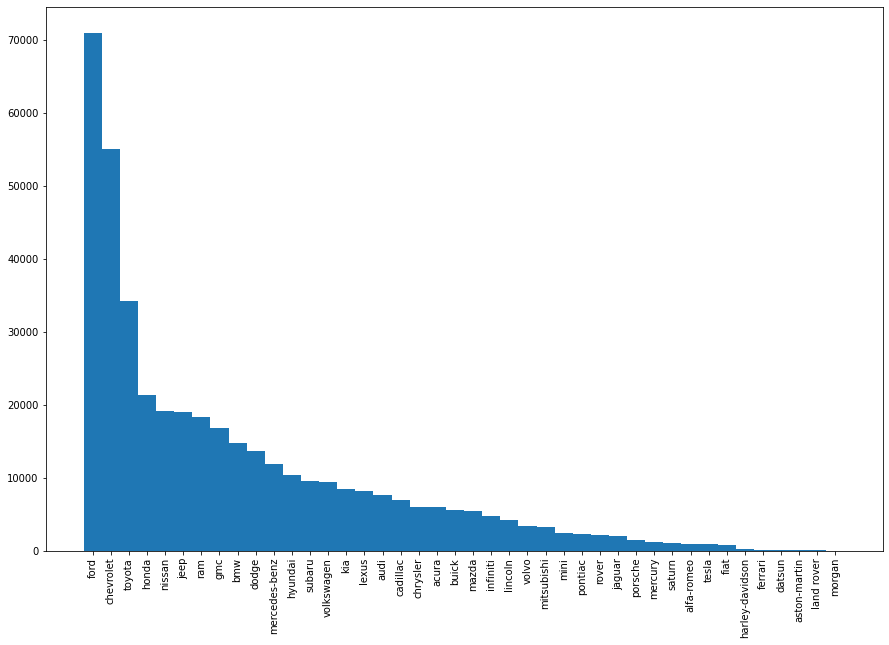

In [45]:
x = (df.groupby(['manufacturer'],as_index = False).count().sort_values('price', ascending = False))['manufacturer'].tolist()
y = (df.groupby(['manufacturer'],as_index = False).count().sort_values('price', ascending = False))['price'].tolist()
fig = plt.figure(figsize=(15,10))
plt.xticks(rotation = 90)
plt.bar(x, y, width=1)

Wir lassen uns die unterschiedlichen Angaben zu den jeweiligen Kategorien anzeigen.

In [46]:
#Information about the categorical variables

print(df["paint_color"].unique())
print(df["condition"].unique())
print(df["type"].unique())
print(df["fuel"].unique())
print(df["cylinders"].unique())
print(df["title_status"].unique())
print(df["type"].unique())
print(df["drive"].unique())
print(df["transmission"].unique())

[nan 'white' 'blue' 'red' 'black' 'silver' 'grey' 'brown' 'yellow'
 'orange' 'green' 'custom' 'purple']
[nan 'good' 'excellent' 'fair' 'like new' 'new' 'salvage']
[nan 'pickup' 'truck' 'other' 'coupe' 'SUV' 'hatchback' 'mini-van' 'sedan'
 'offroad' 'bus' 'van' 'convertible' 'wagon']
[nan 'gas' 'other' 'diesel' 'hybrid' 'electric']
[nan '8 cylinders' '6 cylinders' '4 cylinders' '5 cylinders' 'other'
 '3 cylinders' '10 cylinders' '12 cylinders']
[nan 'clean' 'rebuilt' 'lien' 'salvage' 'missing' 'parts only']
[nan 'pickup' 'truck' 'other' 'coupe' 'SUV' 'hatchback' 'mini-van' 'sedan'
 'offroad' 'bus' 'van' 'convertible' 'wagon']
[nan 'rwd' '4wd' 'fwd']
[nan 'other' 'automatic' 'manual']


Um einen Überblick zu erhalten, wie oft in der jeweiligen Kategorie kein Eintrag vorhanden ist lassen wir uns dies Anzeigen.

In [47]:
df.isnull().sum().sort_values(ascending = False)

county          426880
size            306361
cylinders       177678
condition       174104
VIN             161042
drive           130567
paint_color     130203
type             92858
manufacturer     17646
title_status      8242
lat               6549
long              6549
model             5277
odometer          4400
fuel              3013
transmission      2556
year              1205
description         70
image_url           68
posting_date        68
url                  0
price                0
state                0
region_url           0
region               0
id                   0
dtype: int64

Um die Vorhersage des Preises präziser zu ermöglichen, entfernen wir die Spalten aus dem Dataframe die wir für unnötige erachten:
- county: extrem hohe Anzahl ein Nan einträgen.
- size: extrem hohe Anzahl ein Nan einträgen.
- id, url, region_url, lat, long, vin, image_url, description, geometry: Diese Angaben sind teilweise sehr individuell (z.B. description), oder für eine Preisvorhersage nicht relevant.
- size: Die "größe" des Fahrzeugs ist Modellabhängig und kann somit ebenfalls entfernt werden.
- region: Diese Angabe ist sehr präzise wir nutzen die Angaben in der Kategorie 'state' zur örtlichen Einschränkung.

In [48]:


df.drop([ 'id', 'url', 'region_url', 'lat', 'long', 'VIN', 'image_url',
         'description', 'county','size','region'], axis = 1, inplace = True)
df.head()

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,posting_date
0,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN
1,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN
2,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN
3,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN
4,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN


In der Kategorie "title_status" sind die Angaben [nan 'clean' 'rebuilt' 'lien' 'salvage' 'missing' 'parts only'] vorhanden.(siehe oben) Für eine Preisvorhersage von Fahrzeugen, können die Inserate mit dem Titel 'rebuilt' 'lien' 'salvage' 'missing' 'parts only' jedoch nicht verwendet werden. 

In [49]:

df = df[((df['title_status'] != 'missing') & (df['title_status'] != 'parts only') 
    & (df['title_status'] != 'salvage') & (df['title_status'] != 'rebuilt')
   & (df['title_status'] != 'lien'))]


Aussortieren von Inseraten mit unrealistischen Preisen

In [50]:
df = df[((df['price'] < 500000) & (df['price'] > 100))]

Jetzt lassen wir uns die Fahrzeuginserate anhand der Baujahre und des zugehörigen Preises anzeigen.

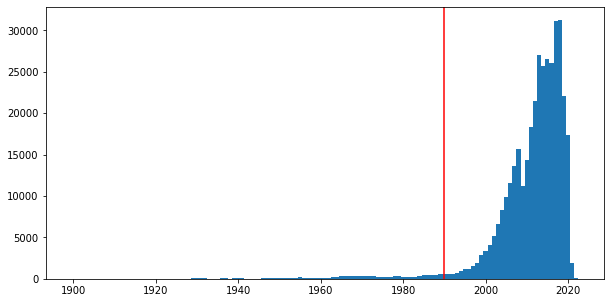

In [51]:
starting_year = 1990
x = (df.groupby(['year'],as_index = False).count())['year'].tolist()
y = (df.groupby(['year'],as_index = False).count())['price'].tolist()
fig = plt.figure(figsize=(10,5))
plt.bar(x, y, width=1)
plt.axvline(starting_year, color = 'red')

Die Anzahl an Fahrzeugen die vor 1990 gebaut wurden ist sehr gering und die Preise niedrig, für diese Fahrzeuge ist keine genau Preis Ermittlung möglich.

In [52]:

df = df[df['year'] > starting_year]


Fahrzeuge mit sehr hohen Tachostand (höchsten 1%) können ebenfalls ignoriert werden.

In [53]:
top1 = np.nanpercentile(df['odometer'], 99)
df = df[df['odometer'] < top1]

Fahrzeuge die keine Angeben in den Spalten fuel, transmission, manufacturer und model können ebenfalls vernächlässigt werden, da diese Angaben hohe Priorität haben.

In [54]:
#delete unknown fuel, transmission and title_status instances

df.dropna(subset = ['fuel', 'transmission', 'title_status'], axis = 0, inplace = True)
df = df[~df['manufacturer'].isnull()]
df = df[~df['model'].isnull()]
df.shape

(334271, 15)

Um im späteren Verlauf eine Prediction zu ermöglichen ersetzen wir in den restlichen Spalten die Nan Angaben durch unknowen bzw. not specified

In [55]:
#replace missing condition values with 'not specified'

df['condition'].fillna('not specified', inplace = True)
df['paint_color'].fillna('unknown', inplace = True)


Da in einigen inseraten Modell verschieden beschrieben werden z.B. F150, F150 good condition, F-150 beschränken wir uns auf das erste Wort in der Beschreibung und entfernen alle Modelle die anschließend weniger als 150 mal auftreten. Desweitern fügen wir den manufacturer in der Spalte model hinzu, um zu vermeiden, dass Fahrzeuge die den gleichen Modellnamen jedoch von unterschiedlichen Herstellern sind, zusammengfügt werden. Dies machen wir in einem speraten Dataframe um uns die Unterschiede anzeigen lassen zu können

In [56]:


model_list = df['model'].tolist()
model_list = map(str, model_list)
model_list = [x.lower().strip() for x in model_list]
my_list = [car_model.split()[0] for car_model in model_list]
my_list = [x.replace(' ', '').replace('-', '').replace('/', '') for x in my_list]

df['car_model'] = my_list
df['car_model'] = df['manufacturer'] + " " + df['car_model']

new_car_models = (df.groupby(['car_model'], as_index= False).count())[['manufacturer', 'car_model', 'price']]
new_car_models = new_car_models.rename(columns={'price': 'count'})
only_common_models = new_car_models[new_car_models['count'] > 150]
#evtl löschen
print('Alle models ', len(new_car_models['count']))
print('models mit mehr als 150 Einträgen: ', len(only_common_models['count']))
print('Prozentualeranteil an gelöschten models:', round((1-len(only_common_models['count'])/len(new_car_models['count'])) * 100, 2))
print()
print('Gesamtanzahl an Inseraten: ', len(df['price']))
print('Verbleibende Inserate: ', sum(only_common_models['count']))
print('Prozentualeranteil an gelöschten Inseraten ', round((1-sum(only_common_models['count'])/len(df['price'])) * 100, 2))

Alle models  2459
models mit mehr als 150 Einträgen:  303
Prozentualeranteil an gelöschten models: 87.68

Gesamtanzahl an Inseraten:  334271
Verbleibende Inserate:  306723
Prozentualeranteil an gelöschten Inseraten  8.24


Um einen graphischen Überblick zu erhalten wieviele Fahrzeugemodell und Inserate gelöscht werden, wenn wir die mindest Anzahl auf 150 setzen lassen wir uns dies Anzeigen.

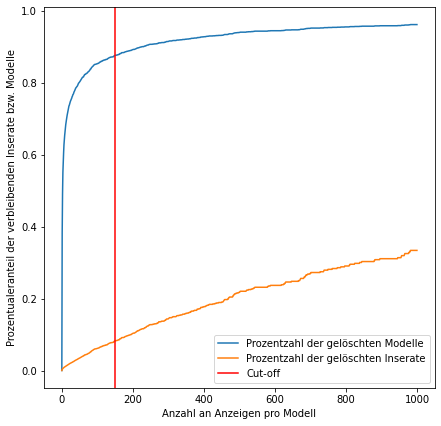

In [57]:
removed_models_list = []
removed_instances_list = []

for i in range(0,1000):
    only_common_models_v2 = new_car_models[new_car_models['count']>i]
    models_removed = 1-len(only_common_models_v2['count'])/len(new_car_models['count'])
    instances_removed = 1-sum(only_common_models_v2['count'])/len(df['price'])
    
    removed_models_list.append(models_removed)
    removed_instances_list.append(instances_removed)

fig = plt.figure(figsize=(7,7))
plt.plot(removed_models_list, label = 'Prozentzahl der gelöschten Modelle')
plt.plot(removed_instances_list, label = 'Prozentzahl der gelöschten Inserate')
plt.axvline(150 , color = 'red', label = 'Cut-off')
plt.ylabel('Prozentualeranteil der verbleibenden Inserate bzw. Modelle')
plt.xlabel('Anzahl an Anzeigen pro Modell')
plt.legend()

Wir sind mit unsere Grenze von min. 150 Fahrzeugen zufrieden, da noch genügend Daten für eine Preisvorhersage vorhanden sind und trotzdem stark genüg reduziert wurde um die Gefahr des overfittings zu veringern. 
Wir übernehmen unsere Änderungen im Hauptdataframe. Durch das zusammenfügen von manufacturer und model können wir die beiden Spalten ebenfalls dropen.

In [58]:
df = df[df['car_model'].isin(only_common_models['car_model'].tolist())]
df.drop('model', axis = 1, inplace = True)
df.drop('manufacturer',axis = 1, inplace= True)


In [59]:
df.head(50)

,price,year,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,posting_date,car_model
27,33590,2014.0,good,8 cylinders,gas,57923.0,clean,other,NaN,pickup,white,al,2021-05-04T12:31:18-0500,gmc sierra
28,22590,2010.0,good,8 cylinders,gas,71229.0,clean,other,NaN,pickup,blue,al,2021-05-04T12:31:08-0500,chevrolet silverado
29,39590,2020.0,good,8 cylinders,gas,19160.0,clean,other,NaN,pickup,red,al,2021-05-04T12:31:25-0500,chevrolet silverado
30,30990,2017.0,good,8 cylinders,gas,41124.0,clean,other,NaN,pickup,red,al,2021-05-04T10:41:31-0500,toyota tundra
31,15000,2013.0,excellent,6 cylinders,gas,128000.0,clean,automatic,rwd,truck,black,al,2021-05-03T14:02:03-0500,ford f150
32,27990,2012.0,good,8 cylinders,gas,68696.0,clean,other,4wd,pickup,black,al,2021-05-03T13:41:25-0500,gmc sierra
33,34590,2016.0,good,6 cylinders,gas,29499.0,clean,other,4wd,pickup,silver,al,2021-05-03T12:41:33-0500,chevrolet silverado
34,35000,2019.0,excellent,6 cylinders,gas,43000.0,clean,automatic,4wd,truck,grey,al,2021-05-03T12:12:59-0500,toyota tacoma
35,29990,2016.0,good,6 cylinders,gas,17302.0,clean,other,4wd,pickup,red,al,2021-05-03T11:31:14-0500,chevrolet colorado
36,38590,2011.0,good,8 cylinders,gas,30237.0,clean,other,rwd,other,red,al,2021-05-03T07:50:35-0500,chevrolet corvette


Wir lassen uns das aktuelle Datafield anzeigen um einen Überblick zubekommen.

In [60]:
df.iloc[:,12]

27        2021-05-04T12:31:18-0500
28        2021-05-04T12:31:08-0500
29        2021-05-04T12:31:25-0500
30        2021-05-04T10:41:31-0500
31        2021-05-03T14:02:03-0500
                    ...           
426875    2021-04-04T03:21:31-0600
426876    2021-04-04T03:21:29-0600
426877    2021-04-04T03:21:17-0600
426878    2021-04-04T03:21:11-0600
426879    2021-04-04T03:21:07-0600
Name: posting_date, Length: 306723, dtype: object

In [61]:

i=0
for x in df.posting_date:
    df.iloc[i,12]=x[:7:]
    i=i+1

df
print(df["posting_date"].unique())



['2021-05' '2021-04']


Da alle Inserate innerhalb der letzten zwei Monaten angeboten wurden können wir die Splate 'posting_date' ebenfalls entfernen.

In [62]:
df=df.drop('posting_date',axis=1)

In der Splate cylinders ersetzen wir die Werte Nan durch den Median und löschen die Einträge mit der Angabe 'others'.

In [63]:
df = df[df['cylinders'] != 'other']
dftest = df.copy()
test = df[df['cylinders'].notnull()].copy()
test['cylinders'] = [int(cyl.split()[0]) for cyl in test['cylinders']]
med = test.groupby('car_model')['cylinders'].median()
merged = pd.merge(dftest, med, on = 'car_model', how = 'left')
merged['cylinders_y'].fillna(med.median(), inplace = True)
merged['cylinders_x'].fillna(merged['cylinders_y'], inplace = True)

li = []
for cyl in merged['cylinders_x']:
    if type(cyl) == str:
        li.append(cyl)
    else:
        li.append(str(int(cyl)) + " cylinders")

df['cylinders'] = li


Wir fügen in der Spalte "drive" bei Einträgen ohne Anagbe den am häuigst auftretenden Werte ein.

In [64]:
dftest = df.copy()
test = df[df['drive'].notnull()].copy()
mode = test.groupby('car_model')['drive'].agg(pd.Series.mode)
merged = pd.merge(dftest, mode, on = 'car_model', how = 'left')
merged['drive_x'].fillna(merged['drive_y'], inplace = True)

df['drive'] = merged['drive_x'].tolist()
df['drive'].unique()

array(['4wd', 'rwd', 'fwd'], dtype=object)

Selbiges führen wir für die Spalte "type" druch.

In [65]:
dftest = df.copy()
test = df[df['type'].notnull()].copy()
mode = test.groupby('car_model')['type'].agg(pd.Series.mode)
merged = pd.merge(dftest, mode, on = 'car_model', how = 'left')
merged['type_x'].fillna(merged['type_y'], inplace = True)

df['type'] = merged['type_x'].tolist()


Um zu überprüfen, ob keine weiteren Nan einträge in den Spalten vorhanden sind zählen wir die Einträge mit Nan in allen Kategorien

In [66]:
df.isnull().sum()

price           0
year            0
condition       0
cylinders       0
fuel            0
odometer        0
title_status    0
transmission    0
drive           0
type            0
paint_color     0
state           0
car_model       0
dtype: int64

Einträge die einen untypisch hohen Preis (dreifcher Durchschnittspreis) haben, entfernen wir ebenfalls aus dem Datensatz.

In [67]:
df = df[df['price'] < (3 * df.groupby('car_model')['price'].transform('mean'))]

Um eine Vorstellung zu bekommen wieviele Einträge und Spalten wir durch unsere Eingrenzungsmaßnahemn entferen konnten lassen wir uns erneut die Dimensionen des Dataframes anzeigen. Wir konnten von einem die Einträge im Dataframe von 426880 x 26 auf 304885 x 13 reduzieren.
Dies entspricht einer Kürzung von 121995 Zeilen und 13 Spalten.

In [68]:
df.shape

(304885, 13)

Wir erstellen eine Kopie des Dataframes um es erneut herstellen zukönnen. Und erstellen die csv Datei clean.

In [69]:
clean = df.copy()

In [70]:
df.to_csv('clean.csv', index = False)

In [ ]:
#creates model as defined in 'reg' and returns test & train evaluation metrics
#default is 80/20 train-test split: industry standard

def updateModel(datafr, test_percentage = 0.2, seed = 7):
    
    #train-test split
    X = datafr.drop('price', axis = 1)
    y = datafr['price']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_percentage, random_state = seed)
    X_train = pd.get_dummies(X_train, drop_first = True)
    X_test = pd.get_dummies(X_test, drop_first = True)
    
    #feature scalin
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    
    #making model + predicting
    reg.fit(X_train, y_train)
    y_pred_test = reg.predict(X_test)
    y_pred_train = reg.predict(X_train)
    
    #computing test & train metrics
    test_metrics = {'r2': round(r2_score(y_test, y_pred_test) * 100, 2),
           'mae': round(mean_absolute_error(y_test, y_pred_test), 2),
           'mse': round(mean_squared_error(y_test, y_pred_test), 2),
           'mape': round(mean_absolute_percentage_error(y_test, y_pred_test) * 100, 2)
           }
    train_metrics = {'r2': round(r2_score(y_train, y_pred_train) * 100, 2),
           'mae': round(mean_absolute_error(y_train, y_pred_train), 2),
           'mse': round(mean_squared_error(y_train, y_pred_train), 2),
           'mape': round(mean_absolute_percentage_error(y_train, y_pred_train) * 100, 2)
           }
    
    return {'test_metrics': test_metrics,
            'train_metrics': train_metrics}

In [72]:
#creates model as defined in 'reg' and returns k fold cross validation metrics
#default is 5-fold CV: industry standard & default scoring is MAE because of easy interpretation

def get_kCVscores(datafr, k = 5, scoring = 'neg_mean_absolute_error'):
    X = datafr.drop('price', axis = 1)
    X = pd.get_dummies(X, drop_first = True)
    y = datafr['price']
    return (cross_val_score(reg, X, y, cv = k, scoring = scoring) * (-1))

In [73]:
#K-means clustering function
def k_means_clustering(datafr, k):
    df_to_return = datafr.copy()
    df_with_dummies = pd.get_dummies(datafr, drop_first = True)
    km = KMeans(n_clusters = k)
    df_to_return['cluster'] = km.fit_predict(df_with_dummies)
    
    return df_to_return

In [74]:
reg = LinearRegression()

In [75]:
df.head(50)


,price,year,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,car_model
27,33590,2014.0,good,8 cylinders,gas,57923.0,clean,other,4wd,pickup,white,al,gmc sierra
28,22590,2010.0,good,8 cylinders,gas,71229.0,clean,other,4wd,pickup,blue,al,chevrolet silverado
29,39590,2020.0,good,8 cylinders,gas,19160.0,clean,other,4wd,pickup,red,al,chevrolet silverado
30,30990,2017.0,good,8 cylinders,gas,41124.0,clean,other,4wd,pickup,red,al,toyota tundra
31,15000,2013.0,excellent,6 cylinders,gas,128000.0,clean,automatic,rwd,truck,black,al,ford f150
32,27990,2012.0,good,8 cylinders,gas,68696.0,clean,other,4wd,pickup,black,al,gmc sierra
33,34590,2016.0,good,6 cylinders,gas,29499.0,clean,other,4wd,pickup,silver,al,chevrolet silverado
34,35000,2019.0,excellent,6 cylinders,gas,43000.0,clean,automatic,4wd,truck,grey,al,toyota tacoma
35,29990,2016.0,good,6 cylinders,gas,17302.0,clean,other,4wd,pickup,red,al,chevrolet colorado
36,38590,2011.0,good,8 cylinders,gas,30237.0,clean,other,rwd,other,red,al,chevrolet corvette


asdfasdfasdf

In [76]:
# df=df.drop(['type'], axis=1)
#df.fillna('unknown')
#df[df.isna().any(axis=1)]

In [77]:
df.shape
#df.head(50)

(304885, 13)

In [78]:
#initial linear regression model
init_metrics = updateModel(df)
def print_metrics(metrics):
    print('test performance:', metrics['test_metrics'])
    print('initial test performance:', init_metrics['test_metrics'])
    print()
    print('train performance:', metrics['train_metrics'])
    print('initial train performance:', init_metrics['train_metrics'])
    print()
    print('change in test MAE:', round((init_metrics['test_metrics']['mae'] - metrics['test_metrics']['mae']) / 
      (init_metrics['test_metrics']['mae']) * 100, 2), '%')
print_metrics(init_metrics)

test performance: {'r2': 76.86, 'mae': 4386.93, 'mse': 45417166.76, 'mape': 158.1}
initial test performance: {'r2': 76.86, 'mae': 4386.93, 'mse': 45417166.76, 'mape': 158.1}

train performance: {'r2': 77.0, 'mae': 4402.37, 'mse': 45234351.07, 'mape': 156.76}
initial train performance: {'r2': 77.0, 'mae': 4402.37, 'mse': 45234351.07, 'mape': 156.76}

change in test MAE: 0.0 %


In [79]:
regions_dict = {"state": ["al","ak","az","ar","ca","co","ct","de","dc","fl","ga","hi","id","il","in","ia","ks","ky","la","me","md","ma","mi","mn","ms","mo","mt","ne","nv","nh","nj","nm","ny","nc","nd","oh","ok","or","pa","ri","sc","sd","tn","tx","ut","vt","va","wa","wv","wi","wy"], 
         "region": ["south","west","west","south","west","west","north-east","south","south","south","south","west","west","mid-west","mid-west","mid-west","mid-west","south","south","north-east","south","north-east","mid-west","mid-west","south","mid-west","west","mid-west","west","north-east","north-east","west","north-east","south","mid-west","mid-west","south","west","north-east","north-east","south","mid-west","south","south","west","north-east","south","west","south","mid-west","west"]}
dfState = pd.merge(df, pd.DataFrame(regions_dict), on = 'state', how = 'left').drop('state', axis = 1)
dfState

,price,year,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,car_model,region
0,33590,2014.0,good,8 cylinders,gas,57923.0,clean,other,4wd,pickup,white,gmc sierra,south
1,22590,2010.0,good,8 cylinders,gas,71229.0,clean,other,4wd,pickup,blue,chevrolet silverado,south
2,39590,2020.0,good,8 cylinders,gas,19160.0,clean,other,4wd,pickup,red,chevrolet silverado,south
3,30990,2017.0,good,8 cylinders,gas,41124.0,clean,other,4wd,pickup,red,toyota tundra,south
4,15000,2013.0,excellent,6 cylinders,gas,128000.0,clean,automatic,rwd,truck,black,ford f150,south
...,...,...,...,...,...,...,...,...,...,...,...,...,...
304880,23590,2019.0,good,6 cylinders,gas,32226.0,clean,other,fwd,sedan,unknown,nissan maxima,west
304881,30590,2020.0,good,5 cylinders,gas,12029.0,clean,other,fwd,sedan,red,volvo s60,west
304882,34990,2020.0,good,4 cylinders,diesel,4174.0,clean,other,fwd,hatchback,white,cadillac xt4,west
304883,28990,2018.0,good,6 cylinders,gas,30112.0,clean,other,fwd,sedan,silver,lexus es,west


In [80]:
#new metrics

binned_states_metrics = updateModel(dfState)
print_metrics(binned_states_metrics)

test performance: {'r2': 76.63, 'mae': 4394.56, 'mse': 45882148.63, 'mape': 160.6}
initial test performance: {'r2': 76.86, 'mae': 4386.93, 'mse': 45417166.76, 'mape': 158.1}

train performance: {'r2': 76.73, 'mae': 4414.4, 'mse': 45749827.99, 'mape': 159.24}
initial train performance: {'r2': 77.0, 'mae': 4402.37, 'mse': 45234351.07, 'mape': 156.76}

change in test MAE: -0.17 %


In [81]:
dfDropState = df.drop('state', axis = 1)
dfDropState

,price,year,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,car_model
27,33590,2014.0,good,8 cylinders,gas,57923.0,clean,other,4wd,pickup,white,gmc sierra
28,22590,2010.0,good,8 cylinders,gas,71229.0,clean,other,4wd,pickup,blue,chevrolet silverado
29,39590,2020.0,good,8 cylinders,gas,19160.0,clean,other,4wd,pickup,red,chevrolet silverado
30,30990,2017.0,good,8 cylinders,gas,41124.0,clean,other,4wd,pickup,red,toyota tundra
31,15000,2013.0,excellent,6 cylinders,gas,128000.0,clean,automatic,rwd,truck,black,ford f150
...,...,...,...,...,...,...,...,...,...,...,...,...
426875,23590,2019.0,good,6 cylinders,gas,32226.0,clean,other,fwd,sedan,unknown,nissan maxima
426876,30590,2020.0,good,5 cylinders,gas,12029.0,clean,other,fwd,sedan,red,volvo s60
426877,34990,2020.0,good,4 cylinders,diesel,4174.0,clean,other,fwd,hatchback,white,cadillac xt4
426878,28990,2018.0,good,6 cylinders,gas,30112.0,clean,other,fwd,sedan,silver,lexus es


In [82]:
#new metrics

drop_state_metrics = updateModel(dfDropState)
print_metrics(drop_state_metrics)

test performance: {'r2': 76.4, 'mae': 4426.31, 'mse': 46329441.53, 'mape': 159.4}
initial test performance: {'r2': 76.86, 'mae': 4386.93, 'mse': 45417166.76, 'mape': 158.1}

train performance: {'r2': 76.51, 'mae': 4443.93, 'mse': 46183955.37, 'mape': 157.73}
initial train performance: {'r2': 77.0, 'mae': 4402.37, 'mse': 45234351.07, 'mape': 156.76}

change in test MAE: -0.9 %


In [83]:
dfNoCarModel = df.drop('car_model', axis = 1)
dfNoCarModel

,price,year,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
27,33590,2014.0,good,8 cylinders,gas,57923.0,clean,other,4wd,pickup,white,al
28,22590,2010.0,good,8 cylinders,gas,71229.0,clean,other,4wd,pickup,blue,al
29,39590,2020.0,good,8 cylinders,gas,19160.0,clean,other,4wd,pickup,red,al
30,30990,2017.0,good,8 cylinders,gas,41124.0,clean,other,4wd,pickup,red,al
31,15000,2013.0,excellent,6 cylinders,gas,128000.0,clean,automatic,rwd,truck,black,al
...,...,...,...,...,...,...,...,...,...,...,...,...
426875,23590,2019.0,good,6 cylinders,gas,32226.0,clean,other,fwd,sedan,unknown,wy
426876,30590,2020.0,good,5 cylinders,gas,12029.0,clean,other,fwd,sedan,red,wy
426877,34990,2020.0,good,4 cylinders,diesel,4174.0,clean,other,fwd,hatchback,white,wy
426878,28990,2018.0,good,6 cylinders,gas,30112.0,clean,other,fwd,sedan,silver,wy


In [84]:
no_car_model_metrics = updateModel(dfNoCarModel)
print_metrics(no_car_model_metrics)

test performance: {'r2': 70.41, 'mae': 5229.15, 'mse': 58080019.84, 'mape': 170.18}
initial test performance: {'r2': 76.86, 'mae': 4386.93, 'mse': 45417166.76, 'mape': 158.1}

train performance: {'r2': 70.64, 'mae': 5246.55, 'mse': 57736764.42, 'mape': 168.12}
initial train performance: {'r2': 77.0, 'mae': 4402.37, 'mse': 45234351.07, 'mape': 156.76}

change in test MAE: -19.2 %


In [85]:
dfBinnedYear = df.copy()
dfBinnedYear['year'] = pd.cut(df['year'], 3, labels = ['vintage', 'medium age', 'recent'])
dfBinnedYear

,price,year,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,car_model
27,33590,recent,good,8 cylinders,gas,57923.0,clean,other,4wd,pickup,white,al,gmc sierra
28,22590,medium age,good,8 cylinders,gas,71229.0,clean,other,4wd,pickup,blue,al,chevrolet silverado
29,39590,recent,good,8 cylinders,gas,19160.0,clean,other,4wd,pickup,red,al,chevrolet silverado
30,30990,recent,good,8 cylinders,gas,41124.0,clean,other,4wd,pickup,red,al,toyota tundra
31,15000,recent,excellent,6 cylinders,gas,128000.0,clean,automatic,rwd,truck,black,al,ford f150
...,...,...,...,...,...,...,...,...,...,...,...,...,...
426875,23590,recent,good,6 cylinders,gas,32226.0,clean,other,fwd,sedan,unknown,wy,nissan maxima
426876,30590,recent,good,5 cylinders,gas,12029.0,clean,other,fwd,sedan,red,wy,volvo s60
426877,34990,recent,good,4 cylinders,diesel,4174.0,clean,other,fwd,hatchback,white,wy,cadillac xt4
426878,28990,recent,good,6 cylinders,gas,30112.0,clean,other,fwd,sedan,silver,wy,lexus es


In [86]:
binned_year_metrics = updateModel(dfBinnedYear)
print_metrics(binned_year_metrics)

test performance: {'r2': 73.1, 'mae': 4912.02, 'mse': 52794985.4, 'mape': 160.31}
initial test performance: {'r2': 76.86, 'mae': 4386.93, 'mse': 45417166.76, 'mape': 158.1}

train performance: {'r2': 73.19, 'mae': 4933.08, 'mse': 52719871.16, 'mape': 159.39}
initial train performance: {'r2': 77.0, 'mae': 4402.37, 'mse': 45234351.07, 'mape': 156.76}

change in test MAE: -11.97 %


In [87]:
dfAge = df.copy()
dfAge['age'] = [2022 - x for x in df['year'].tolist()]
dfAge.drop('year', axis=1, inplace = True)
dfAge

,price,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,car_model,age
27,33590,good,8 cylinders,gas,57923.0,clean,other,4wd,pickup,white,al,gmc sierra,8.0
28,22590,good,8 cylinders,gas,71229.0,clean,other,4wd,pickup,blue,al,chevrolet silverado,12.0
29,39590,good,8 cylinders,gas,19160.0,clean,other,4wd,pickup,red,al,chevrolet silverado,2.0
30,30990,good,8 cylinders,gas,41124.0,clean,other,4wd,pickup,red,al,toyota tundra,5.0
31,15000,excellent,6 cylinders,gas,128000.0,clean,automatic,rwd,truck,black,al,ford f150,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
426875,23590,good,6 cylinders,gas,32226.0,clean,other,fwd,sedan,unknown,wy,nissan maxima,3.0
426876,30590,good,5 cylinders,gas,12029.0,clean,other,fwd,sedan,red,wy,volvo s60,2.0
426877,34990,good,4 cylinders,diesel,4174.0,clean,other,fwd,hatchback,white,wy,cadillac xt4,2.0
426878,28990,good,6 cylinders,gas,30112.0,clean,other,fwd,sedan,silver,wy,lexus es,4.0


In [88]:
age_metrics = updateModel(dfAge)
print_metrics(age_metrics)

test performance: {'r2': 76.86, 'mae': 4386.93, 'mse': 45417166.76, 'mape': 158.1}
initial test performance: {'r2': 76.86, 'mae': 4386.93, 'mse': 45417166.76, 'mape': 158.1}

train performance: {'r2': 77.0, 'mae': 4402.37, 'mse': 45234351.07, 'mape': 156.76}
initial train performance: {'r2': 77.0, 'mae': 4402.37, 'mse': 45234351.07, 'mape': 156.76}

change in test MAE: 0.0 %


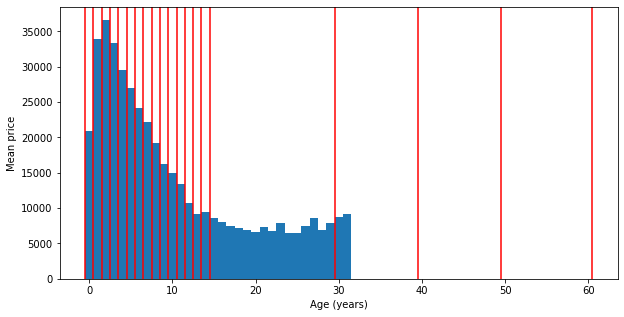

In [89]:
#we can clearly see a U-shaped pricing behavior in function of car age
#in addition, we can identify age categories with similar pricing behavior

dfAgeCat = dfAge.copy()
thresholds = [50,40,30,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1]
groups = ['over 50','40-49','30-39','15-29','14','13','12','11','10','9','8','7','6','5','4','3','2','1']

x = (dfAgeCat.groupby(['age'],as_index = False).mean())['age'].tolist()
y = (dfAgeCat.groupby(['age'],as_index = False).mean())['price'].tolist()
fig = plt.figure(figsize=[10,5])
plt.ylabel('Mean price')
plt.xlabel('Age (years)')
plt.bar(x, y, width=1)
for t in thresholds:
    plt.axvline(t-0.5, color = 'red')

plt.axvline(-0.5, color = 'red')
plt.axvline(60.5, color = 'red')

In [90]:
arr = np.array(dfAgeCat['age'].tolist())
for t in thresholds:
    prevArr = arr
    arr = np.where(prevArr >= t, -t, prevArr)
    
prevArr = arr
dfAgeCat['age_group'] = np.where(prevArr >= 0, 'new', prevArr).tolist()

for i in range(len(thresholds)):
     toReplace = str(float(-thresholds[i]))
     dfAgeCat['age_group'].replace(toReplace, groups[i], inplace =  True)

dfAgeCat.drop('age', axis=1, inplace=True)    
print(dfAgeCat['age_group'].unique())
dfAgeCat

['8' '12' '2' '5' '9' '10' '6' '3' '11' '30-39' '4' '15-29' '7' '14' '13'
 '1' 'new']


,price,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,car_model,age_group
27,33590,good,8 cylinders,gas,57923.0,clean,other,4wd,pickup,white,al,gmc sierra,8
28,22590,good,8 cylinders,gas,71229.0,clean,other,4wd,pickup,blue,al,chevrolet silverado,12
29,39590,good,8 cylinders,gas,19160.0,clean,other,4wd,pickup,red,al,chevrolet silverado,2
30,30990,good,8 cylinders,gas,41124.0,clean,other,4wd,pickup,red,al,toyota tundra,5
31,15000,excellent,6 cylinders,gas,128000.0,clean,automatic,rwd,truck,black,al,ford f150,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
426875,23590,good,6 cylinders,gas,32226.0,clean,other,fwd,sedan,unknown,wy,nissan maxima,3
426876,30590,good,5 cylinders,gas,12029.0,clean,other,fwd,sedan,red,wy,volvo s60,2
426877,34990,good,4 cylinders,diesel,4174.0,clean,other,fwd,hatchback,white,wy,cadillac xt4,2
426878,28990,good,6 cylinders,gas,30112.0,clean,other,fwd,sedan,silver,wy,lexus es,4


In [91]:
age_cat_metrics = updateModel(dfAgeCat)
print_metrics(age_cat_metrics)

test performance: {'r2': 78.27, 'mae': 4259.71, 'mse': 42658855.67, 'mape': 152.49}
initial test performance: {'r2': 76.86, 'mae': 4386.93, 'mse': 45417166.76, 'mape': 158.1}

train performance: {'r2': 78.46, 'mae': 4263.5, 'mse': 42353439.13, 'mape': 151.73}
initial train performance: {'r2': 77.0, 'mae': 4402.37, 'mse': 45234351.07, 'mape': 156.76}

change in test MAE: 2.9 %


condition


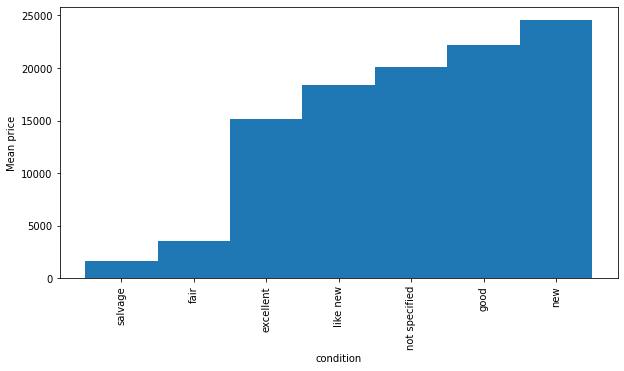

cylinders


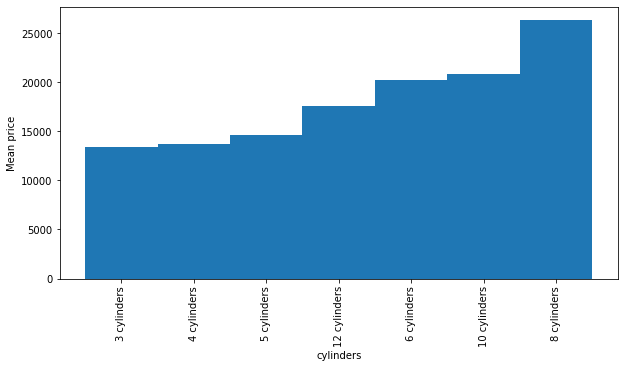

fuel


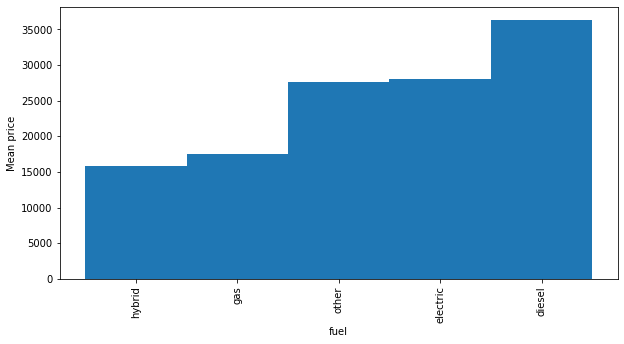

title_status


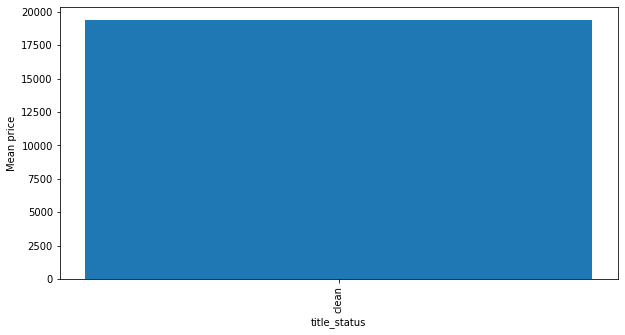

transmission


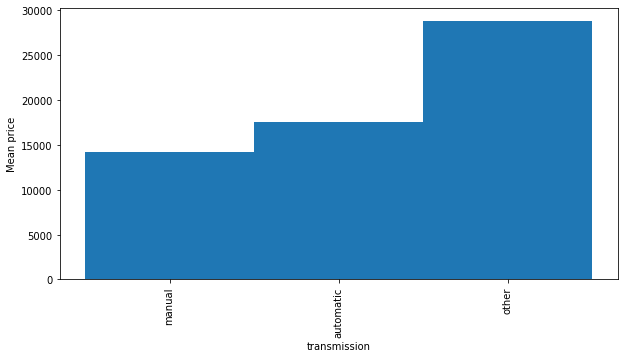

drive


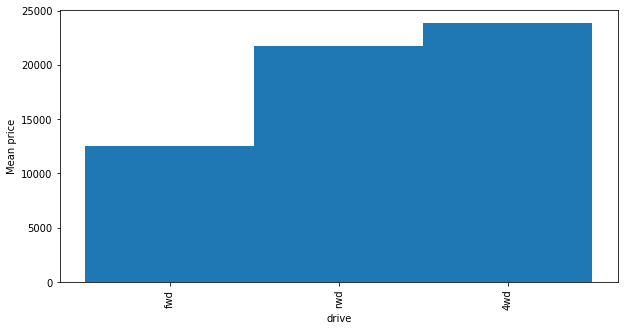

type


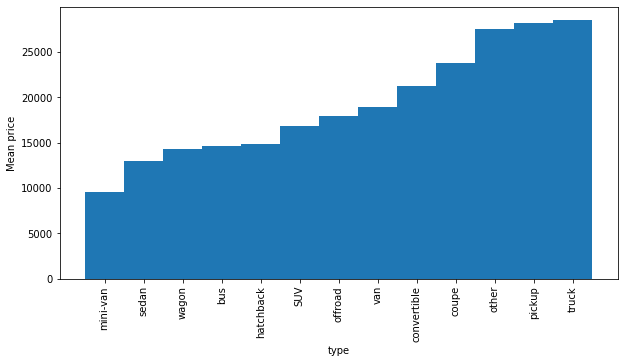

paint_color


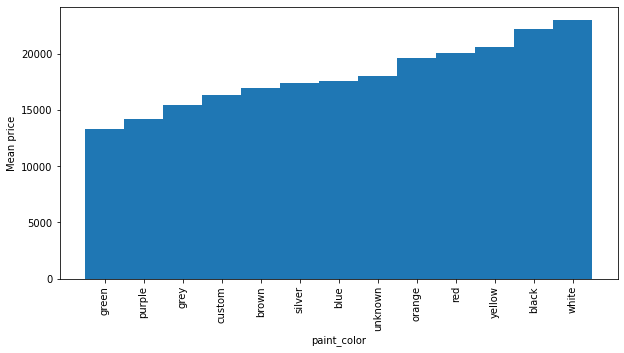

state


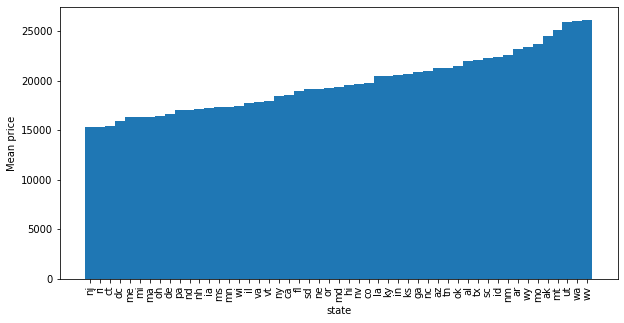

In [92]:
dfPlots = dfAge.copy()
for feat in dfAgeCat.drop(['price','odometer','car_model','age_group'], axis = 1).columns:
    print(feat)
    x = (dfPlots.groupby(feat, as_index = False).mean()).sort_values(by = ['price'])[feat]
    y = (dfPlots.groupby(feat, as_index = False).mean()).sort_values(by = ['price'])['price']
    fig = plt.figure(figsize=[10,5])
    plt.xlabel(feat)
    plt.ylabel('Mean price')
    plt.xticks(rotation = 90)
    plt.bar(x, y, width=1)
    plt.show()

In [93]:
dfCondition = df.copy()

dfCondition['condition'].replace('new', 6, inplace =  True)
dfCondition['condition'].replace('like new', 5, inplace =  True)
dfCondition['condition'].replace('excellent', 4, inplace =  True)
dfCondition['condition'].replace('good', 3, inplace =  True)
dfCondition['condition'].replace('fair', 2, inplace =  True)
dfCondition['condition'].replace('salvage', 1, inplace =  True)
dfCondition['condition'].replace('not specified', 3, inplace =  True)

dfCondition['condition'].unique()

array([3, 4, 2, 5, 6, 1], dtype=int64)

In [94]:
condition_metrics = updateModel(dfCondition)
print_metrics(condition_metrics)

test performance: {'r2': 76.85, 'mae': 4388.42, 'mse': 45445963.07, 'mape': 157.71}
initial test performance: {'r2': 76.86, 'mae': 4386.93, 'mse': 45417166.76, 'mape': 158.1}

train performance: {'r2': 76.98, 'mae': 4404.34, 'mse': 45259362.57, 'mape': 156.41}
initial train performance: {'r2': 77.0, 'mae': 4402.37, 'mse': 45234351.07, 'mape': 156.76}

change in test MAE: -0.03 %


In [95]:
dfColors = df.copy()
dfColors['paint_color'].replace(['unknown', 'blue', 'silver', 'grey', 'green', 'custom', 'yellow', 'brown', 'purple'], 'other_colors', inplace =  True)
dfColors['paint_color'].unique()

array(['white', 'other_colors', 'red', 'black', 'orange'], dtype=object)

In [96]:
color_metrics = updateModel(dfColors)
print_metrics(color_metrics)

test performance: {'r2': 76.77, 'mae': 4384.41, 'mse': 45597803.36, 'mape': 159.26}
initial test performance: {'r2': 76.86, 'mae': 4386.93, 'mse': 45417166.76, 'mape': 158.1}

train performance: {'r2': 76.9, 'mae': 4399.09, 'mse': 45417799.06, 'mape': 157.98}
initial train performance: {'r2': 77.0, 'mae': 4402.37, 'mse': 45234351.07, 'mape': 156.76}

change in test MAE: 0.06 %


In [97]:
dfMPY = dfAge.copy()
MPY_temp = []

dfMPY['miles_per_year'] = [dfMPY['odometer'][i]/(dfMPY['age'][i]+0.001) for i in dfMPY.index.tolist()]
dfMPY.drop(['odometer', 'age'], axis=1, inplace=True)
dfMPY

,price,condition,cylinders,fuel,title_status,transmission,drive,type,paint_color,state,car_model,miles_per_year
27,33590,good,8 cylinders,gas,clean,other,4wd,pickup,white,al,gmc sierra,7239.470066
28,22590,good,8 cylinders,gas,clean,other,4wd,pickup,blue,al,chevrolet silverado,5935.255395
29,39590,good,8 cylinders,gas,clean,other,4wd,pickup,red,al,chevrolet silverado,9575.212394
30,30990,good,8 cylinders,gas,clean,other,4wd,pickup,red,al,toyota tundra,8223.155369
31,15000,excellent,6 cylinders,gas,clean,automatic,rwd,truck,black,al,ford f150,14220.642151
...,...,...,...,...,...,...,...,...,...,...,...,...
426875,23590,good,6 cylinders,gas,clean,other,fwd,sedan,unknown,wy,nissan maxima,10738.420526
426876,30590,good,5 cylinders,gas,clean,other,fwd,sedan,red,wy,volvo s60,6011.494253
426877,34990,good,4 cylinders,diesel,clean,other,fwd,hatchback,white,wy,cadillac xt4,2085.957021
426878,28990,good,6 cylinders,gas,clean,other,fwd,sedan,silver,wy,lexus es,7526.118470


In [98]:
MPY_metrics = updateModel(dfMPY)
print_metrics(MPY_metrics)

test performance: {'r2': 51.95, 'mae': 7028.9, 'mse': 94319015.37, 'mape': 161.89}
initial test performance: {'r2': 76.86, 'mae': 4386.93, 'mse': 45417166.76, 'mape': 158.1}

train performance: {'r2': 51.94, 'mae': 7073.06, 'mse': 94502003.38, 'mape': 163.05}
initial train performance: {'r2': 77.0, 'mae': 4402.37, 'mse': 45234351.07, 'mape': 156.76}

change in test MAE: -60.22 %


In [99]:
dfNoCyl = df.drop('cylinders', axis = 1)
dfNoCyl

,price,year,condition,fuel,odometer,title_status,transmission,drive,type,paint_color,state,car_model
27,33590,2014.0,good,gas,57923.0,clean,other,4wd,pickup,white,al,gmc sierra
28,22590,2010.0,good,gas,71229.0,clean,other,4wd,pickup,blue,al,chevrolet silverado
29,39590,2020.0,good,gas,19160.0,clean,other,4wd,pickup,red,al,chevrolet silverado
30,30990,2017.0,good,gas,41124.0,clean,other,4wd,pickup,red,al,toyota tundra
31,15000,2013.0,excellent,gas,128000.0,clean,automatic,rwd,truck,black,al,ford f150
...,...,...,...,...,...,...,...,...,...,...,...,...
426875,23590,2019.0,good,gas,32226.0,clean,other,fwd,sedan,unknown,wy,nissan maxima
426876,30590,2020.0,good,gas,12029.0,clean,other,fwd,sedan,red,wy,volvo s60
426877,34990,2020.0,good,diesel,4174.0,clean,other,fwd,hatchback,white,wy,cadillac xt4
426878,28990,2018.0,good,gas,30112.0,clean,other,fwd,sedan,silver,wy,lexus es


In [100]:
no_cyl_metrics = updateModel(dfNoCyl)
print_metrics(no_cyl_metrics)

test performance: {'r2': 76.67, 'mae': 4397.35, 'mse': 45790975.66, 'mape': 158.12}
initial test performance: {'r2': 76.86, 'mae': 4386.93, 'mse': 45417166.76, 'mape': 158.1}

train performance: {'r2': 76.79, 'mae': 4416.62, 'mse': 45641928.98, 'mape': 156.87}
initial train performance: {'r2': 77.0, 'mae': 4402.37, 'mse': 45234351.07, 'mape': 156.76}

change in test MAE: -0.24 %


In [101]:
dfNoType = df.drop('type', axis = 1)
dfNoType

,price,year,condition,cylinders,fuel,odometer,title_status,transmission,drive,paint_color,state,car_model
27,33590,2014.0,good,8 cylinders,gas,57923.0,clean,other,4wd,white,al,gmc sierra
28,22590,2010.0,good,8 cylinders,gas,71229.0,clean,other,4wd,blue,al,chevrolet silverado
29,39590,2020.0,good,8 cylinders,gas,19160.0,clean,other,4wd,red,al,chevrolet silverado
30,30990,2017.0,good,8 cylinders,gas,41124.0,clean,other,4wd,red,al,toyota tundra
31,15000,2013.0,excellent,6 cylinders,gas,128000.0,clean,automatic,rwd,black,al,ford f150
...,...,...,...,...,...,...,...,...,...,...,...,...
426875,23590,2019.0,good,6 cylinders,gas,32226.0,clean,other,fwd,unknown,wy,nissan maxima
426876,30590,2020.0,good,5 cylinders,gas,12029.0,clean,other,fwd,red,wy,volvo s60
426877,34990,2020.0,good,4 cylinders,diesel,4174.0,clean,other,fwd,white,wy,cadillac xt4
426878,28990,2018.0,good,6 cylinders,gas,30112.0,clean,other,fwd,silver,wy,lexus es


In [102]:
no_type_metrics = updateModel(dfNoType)
print_metrics(no_type_metrics)

test performance: {'r2': 76.8, 'mae': 4395.69, 'mse': 45531601.44, 'mape': 158.2}
initial test performance: {'r2': 76.86, 'mae': 4386.93, 'mse': 45417166.76, 'mape': 158.1}

train performance: {'r2': 76.93, 'mae': 4411.02, 'mse': 45365214.3, 'mape': 156.96}
initial train performance: {'r2': 77.0, 'mae': 4402.37, 'mse': 45234351.07, 'mape': 156.76}

change in test MAE: -0.2 %


In [103]:
#only creating age_groups had a positive impact on performance
#dropping 'type' and binning 'state' into regions had no real impact on performance but made the model more interpretable

df = dfAgeCat
df = pd.merge(df, pd.DataFrame(regions_dict), on = 'state', how = 'left').drop('state', axis = 1)
df.drop('type', axis = 1, inplace = True)
df

,price,condition,cylinders,fuel,odometer,title_status,transmission,drive,paint_color,car_model,age_group,region
0,33590,good,8 cylinders,gas,57923.0,clean,other,4wd,white,gmc sierra,8,south
1,22590,good,8 cylinders,gas,71229.0,clean,other,4wd,blue,chevrolet silverado,12,south
2,39590,good,8 cylinders,gas,19160.0,clean,other,4wd,red,chevrolet silverado,2,south
3,30990,good,8 cylinders,gas,41124.0,clean,other,4wd,red,toyota tundra,5,south
4,15000,excellent,6 cylinders,gas,128000.0,clean,automatic,rwd,black,ford f150,9,south
...,...,...,...,...,...,...,...,...,...,...,...,...
304880,23590,good,6 cylinders,gas,32226.0,clean,other,fwd,unknown,nissan maxima,3,west
304881,30590,good,5 cylinders,gas,12029.0,clean,other,fwd,red,volvo s60,2,west
304882,34990,good,4 cylinders,diesel,4174.0,clean,other,fwd,white,cadillac xt4,2,west
304883,28990,good,6 cylinders,gas,30112.0,clean,other,fwd,silver,lexus es,4,west


In [104]:
reg = LinearRegression()

In [105]:
#linear regression model on the feature engineered df

initLR = updateModel(df)
print_metrics(initLR)

test performance: {'r2': 78.01, 'mae': 4274.14, 'mse': 43161350.66, 'mape': 154.9}
initial test performance: {'r2': 76.86, 'mae': 4386.93, 'mse': 45417166.76, 'mape': 158.1}

train performance: {'r2': 78.17, 'mae': 4280.66, 'mse': 42917007.69, 'mape': 154.31}
initial train performance: {'r2': 77.0, 'mae': 4402.37, 'mse': 45234351.07, 'mape': 156.76}

change in test MAE: 2.57 %


In [106]:
cols = pd.get_dummies(df, drop_first = True).columns

In [107]:
importance = reg.coef_

temp = pd.DataFrame({'feat n°': [x for x in range(len(importance))],'importance': importance})
temp = temp.sort_values('importance')
worst10 = temp[:10]
best10 = temp[-10:]
best10['feat'] = cols[best10['feat n°']]
worst10['feat'] = cols[worst10['feat n°']]

C:\Users\oache\AppData\Local\Temp\ipykernel_15212\692149078.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best10['feat'] = cols[best10['feat n°']]
C:\Users\oache\AppData\Local\Temp\ipykernel_15212\692149078.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  worst10['feat'] = cols[worst10['feat n°']]


<BarContainer object of 10 artists>

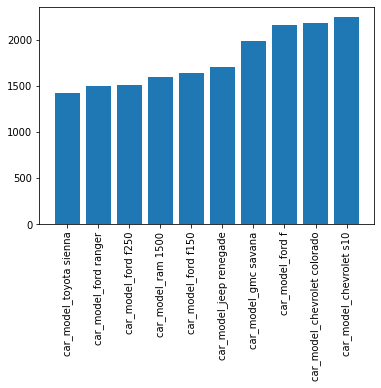

In [108]:
plt.xticks(rotation = 90)
plt.bar(best10['feat'], best10['importance'])

<BarContainer object of 10 artists>

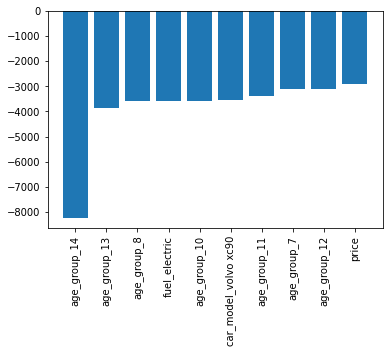

In [109]:
plt.xticks(rotation = 90)
plt.bar(worst10['feat'], worst10['importance'])

#20-tree RF

In [110]:


reg = RandomForestRegressor(n_estimators = 20, random_state = 42)

In [111]:
initRF = updateModel(df)
print_metrics(initRF)

431.24s - Error inserting pydevd breaks.
Traceback (most recent call last):
  File "f:\Python\Python310\lib\site-packages\debugpy\_vendored\pydevd\_pydevd_frame_eval\pydevd_modify_bytecode.py", line 328, in insert_pydevd_breaks
    for new_instruction in get_instructions_to_add(
  File "f:\Python\Python310\lib\site-packages\debugpy\_vendored\pydevd\_pydevd_frame_eval\pydevd_modify_bytecode.py", line 102, in get_instructions_to_add
    Instr("LOAD_CONST", _pydev_stop_at_break, lineno=stop_at_line - 1),
  File "f:\Python\Python310\lib\site-packages\debugpy\_vendored\pydevd\_pydevd_frame_eval\vendored\bytecode\instr.py", line 171, in __init__
    self._set(name, arg, lineno)
  File "f:\Python\Python310\lib\site-packages\debugpy\_vendored\pydevd\_pydevd_frame_eval\vendored\bytecode\instr.py", line 239, in _set
    _check_lineno(lineno)
  File "f:\Python\Python310\lib\site-packages\debugpy\_vendored\pydevd\_pydevd_frame_eval\vendored\bytecode\instr.py", line 74, in _check_lineno
    raise V

: 

: 

In [ ]:
kcv = get_kCVscores(df)
kcv

In [ ]:
print('Cross validated MAE mean:', kcv.mean())
print('Cross validated MAE standard deviation:', kcv.std())

#100-tree RF

In [ ]:


reg = RandomForestRegressor(n_estimators = 100, random_state = 42)

In [ ]:
init100RF = updateModel(df)
print_metrics(init100RF)

In [ ]:
reg = GradientBoostingRegressor(n_estimators = 50, learning_rate = 0.1, max_depth = 1, random_state = 7, loss = 'ls')

In [ ]:
initBoost = updateModel(df)
print_metrics(initBoost)

In [ ]:
reg = MLPRegressor()

In [ ]:
initNN = updateModel(df)
print_metrics(initNN)

In [ ]:
#Elbow plot values
distortions = []
df_with_dummies = pd.get_dummies(df.copy(), drop_first = True)

K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km.fit(df_with_dummies)
    distortions.append(km.inertia_)

#Plotting
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method to determine the optimal k value')
plt.show()

In [ ]:
df_clustering_k2 = k_means_clustering(df, 2)
df_clustering_k2

In [ ]:
df_clustering_k3 = k_means_clustering(df, 3)
df_clustering_k3

In [ ]:
pd.get_dummies(df_clustering_k2, drop_first = True).groupby(['cluster']).median()

In [ ]:
pd.get_dummies(df_clustering_k3, drop_first = True).groupby(['cluster']).median()

In [ ]:
df_to_use = pd.get_dummies(df_clustering_k2, drop_first = True)
k = 2
print('For k = ', k)

list_of_results = []
for i in range(k):
    cluster_df = (df_to_use[df_to_use['cluster']==i]).copy()
    res = updateModel(cluster_df)
    print_metrics(res)
    list_of_results.append(res)

clust_k2_LR_results = list_of_results

In [ ]:
df_to_use = pd.get_dummies(df_clustering_k3, drop_first = True)
k = 3
print('For k = ', k)

list_of_results = []
for i in range(k):
    cluster_df = (df_to_use[df_to_use['cluster']==i]).copy()
    res = updateModel(cluster_df)
    print_metrics(res)
    list_of_results.append(res)

clust_k3_LR_results = list_of_results

In [ ]:
reg = RandomForestRegressor(n_estimators = 20, random_state = 7)

In [ ]:
df_to_use = pd.get_dummies(df_clustering_k2, drop_first = True)
k = 2
print('For k = ', k)

list_of_results = []
for i in range(k):
    cluster_df = (df_to_use[df_to_use['cluster']==i]).copy()
    res = updateModel(cluster_df)
    print_metrics(res)
    list_of_results.append(res)

clust_k2_RF_results = list_of_results

In [ ]:
print_metrics(initRF)

In [ ]:
dfFinal = df_clustering_k2.copy()
dfFinal

In [ ]:
finalPerformance = clust_k2_RF_results
print('Cluster 1:')
print_metrics(finalPerformance[0])
print()
print('Cluster 2:')
print_metrics(finalPerformance[1])

In [ ]:
finalModel = reg
reg

In [ ]:
finalClusters = df_clustering_k2.copy()
pd.get_dummies(finalClusters, drop_first = True).groupby(['cluster']).median()

In [ ]:
dfFinal.to_csv('final')